#Applied Competitive Lab in Data Science
##Exercise 1
David Guedalia

In [333]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from scipy.stats import randint
import seaborn as sns
warnings.filterwarnings('ignore')


In [334]:
df = pd.read_csv("ex3.csv")
df.head(2)

,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,gun_stolen,...,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,state_house_district,state_senate_district
0,194704,877945,2017-06-25,California,Humboldt County (county),NaN,0,0,2.0,0::Unknown,...,NaN,NaN,0::Adult 18+,NaN,0::Manuel Robert Alvidrez,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,2.0,2.0
1,103375,467550,2015-12-15,Georgia,Gwinnett (county),NaN,0,0,7.0,0::Unknown,...,Perp is vic's ex GF's new boyfriend. Shot up m...,NaN,NaN,0::Male||1::Male,0::Eric Cotto||1::Christopher Anderson,NaN,0::Unharmed,0::Victim||1::Subject-Suspect,102.0,45.0


#Question 1

##Preprocessing

I preprocess based of metrics I did last exercise, and I add more metrics to handle features that I had to parse and analyze them, With carfully not using features can cause leakage. 

As I saw the most of the values are less then four.

I used metric we saw in class - binning so I took the first 50 cities

The date feature I decided to break into year and month. Also I saw it important to take also the day in the week it happend as it can make sence theres days with more crime, and maybe it can help to predict the target feature.

I add the feature I calculate the last exercise from kaggle_income.csv

For the participant features I took the number of times it shown as a new feature - hopefully it will improve the performances.

In [335]:
list_to_ten = list(range(1, 4))
def binning_n_guns(x):
    if x in list_to_ten:
        return str(x)
    return "4 or more"

In [336]:
categorical_features = ['state', 'city_or_county', 'year', 'month', 'day', 'n_guns_involved']

In [337]:
features_model_after_prep = ['state', 'city_or_county', 'year', 'month', 'day', 'participant_gender_male', 'participant_gender_female', 'participant_adult', 'n_guns_involved',
                     'participant_teen', 'participant_child', 'gun_stolen_n', 'gun_unstolen_n', 'gun_unknown_n', 'latitude', 'longitude', 'state_mean_income']

In [338]:
def preprocess(df, X_train):
    df["longitude"] = df["longitude"].apply(lambda x : x if -180 <= float(x) <= 80 else df["longitude"].mode()[0])
    df["n_guns_involved"] = df["n_guns_involved"].apply(lambda x:binning_n_guns(x))
    top_cities = df['city_or_county'].value_counts()[:50].index.tolist()
    df['city_or_county'] = df['city_or_county'].apply(lambda x: 'Other_city' if x not in top_cities else x)
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day'] = df['date'].apply(lambda x: x.day_name())
    df["participant_gender"] = df["participant_gender"].fillna('Unknown')
    df['participant_age_group'] = df['participant_age_group'].fillna('Unknown')
    df['gun_stolen'] = df['gun_stolen'].fillna('Unknown')
    df["participant_gender_male"] = df["participant_gender"].apply(lambda x: np.nan if x == 'Unknown' else sum('Male' in s for s in x.split("||")))
    df["participant_gender_female"] = df["participant_gender"].apply(lambda x: np.nan if x == 'Unknown' else sum('Female' in s for s in x.split("||")))
    df["participant_adult"] = df["participant_age_group"].apply(lambda x: np.nan if x == 'Unknown' else sum('Adult' in s for s in x.split("||")))
    df["participant_teen"] = df["participant_age_group"].apply(lambda x: np.nan if x == 'Unknown' else sum('Teen' in s for s in x.split("||")))
    df["participant_child"] = df["participant_age_group"].apply(lambda x: np.nan if x == 'Unknown' else sum('Child' in s for s in x.split("||")))
    df["gun_stolen_n"] = df["gun_stolen"].apply(lambda x: np.nan if x == 'Unknown' else sum('Stolen' in s for s in x.split("||")))
    df["gun_unstolen_n"] = df["participant_age_group"].apply(lambda x: np.nan if x == 'Unknown' else sum('Not-stolen' in s for s in x.split("||")))
    df["gun_unknown_n"] = df["participant_age_group"].apply(lambda x: np.nan if x == 'Unknown' else sum('Unknown' in s for s in x.split("||")))

    df["participant_gender_female"].fillna(X_train["participant_gender_female"].mode()[0], inplace=True)
    df["participant_gender_male"].fillna(X_train["participant_gender_male"].mode()[0], inplace=True)
    df["participant_adult"].fillna(X_train["participant_adult"].mode()[0], inplace=True)
    df["participant_teen"].fillna(X_train["participant_teen"].mode()[0], inplace=True)
    df["participant_child"].fillna(X_train["participant_child"].mode()[0], inplace=True)
    df["gun_stolen_n"].fillna(X_train["gun_stolen_n"].mode()[0], inplace=True)
    df["gun_unstolen_n"].fillna(X_train["gun_unstolen_n"].mode()[0], inplace=True)
    df["gun_unknown_n"].fillna(X_train["gun_unknown_n"].mode()[0], inplace=True)
    df_kaggle_income = pd.read_csv('kaggle_income.csv', encoding='latin-1')
    state_income = df_kaggle_income.groupby('State_Name').agg({'Mean':'mean'}).reset_index().rename(columns={'State_Name':'state', 'Mean':'state_mean_income'})
    df = df.merge(state_income, on='state', how='left')
    df = pd.get_dummies(df,columns=categorical_features,drop_first=True)
    df = df.drop(columns=['date', 'participant_gender', 'participant_age_group', 'gun_stolen'])
    return df

Features I decided to include the model.

In [339]:
features_to_model = ['state', 'city_or_county', 'date', 'participant_gender', 'participant_age_group', 'n_guns_involved',
                   'gun_stolen', 'latitude', 'longitude']

In [340]:

target = ['n_killed']

In [341]:
df = df[features_to_model + target]
X = df[features_to_model]
y = df[target]

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [343]:
X_train = preprocess(X_train, X_train).reset_index(drop=True)

In [344]:
ind_train = X_train.loc[pd.isnull(X_train).any(1), :].index.values

In [345]:
X_test = preprocess(X_test, X_train).reset_index(drop=True)

In [346]:
ind_test = X_test.loc[pd.isnull(X_test).any(1), :].index.values

In [347]:
y_test['n_killed'] = y_test['n_killed'].apply(lambda x: abs(x))
y_train['n_killed'] = y_train['n_killed'].apply(lambda x: abs(x))

In [348]:
X_test

,latitude,longitude,participant_gender_male,participant_gender_female,participant_adult,participant_teen,participant_child,gun_stolen_n,gun_unstolen_n,gun_unknown_n,...,month_12,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,n_guns_involved_2.0,n_guns_involved_3.0,n_guns_involved_4 or more
0,38.3726,-81.6572,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,42.4592,-70.9387,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,42.2512,-71.8305,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,40.7472,-73.9934,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,39.9250,-75.1040,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,36.1373,-115.1360,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
7496,37.3715,-121.9300,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
7497,40.9540,-75.9736,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7498,39.1875,-76.7900,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [349]:
X_train.drop(X_train.index[ind_train], inplace=True)
y_train.drop(y_train.index[ind_train], inplace=True)
X_test.drop(X_test.index[[ind_test]], inplace=True)
y_test.drop(y_test.index[ind_test], inplace=True)

In [350]:
model_lr = LinearRegression().fit(X_train, y_train)
model_rf = RandomForestRegressor().fit(X_train, y_train)

In [351]:
rmse_lreg = np.sqrt(mean_squared_error(model_lr.predict(X_test), y_test))
rmse_rfreg = np.sqrt(mean_squared_error(model_rf.predict(X_test), y_test))


print("RMSE Linear Regression: {:.2f}".format(rmse_lreg))
print("RMSE Random Forest Regressor: {:.2f}".format(rmse_rfreg))

RMSE Linear Regression: 0.49
RMSE Random Forest Regressor: 0.49


RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations.

I chose Linear Regression as it is basic and simple model for regression problems,
its advantages are that the model is easy to made and from the coefficients we can understand the features.
Thedisadvantages are that the model is very basic and as it is name only linear.

Also I chose Random Forest Regressor because it is good model for tabular data.
This model advantages usually it gives well predictions, and it is not linear.
Its disadvantages are that hard to understand the predictions.

#Question 2

As we discussed in class, I chose to use GridSearchCV and RandomizedSearchCV with RandomForestRegressor model.

In [352]:

model = RandomForestRegressor(random_state=10)

params_grid = {
    'n_estimators': [2, 4, 8, 16, 64, 256],
    'min_samples_leaf': [2, 4, 8, 16, 32],
}

n_configs = np.array([len(l) for key, l in params_grid.items()]).prod()
print('n_configs', n_configs)

grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=5, verbose=1, scoring=make_scorer(mean_squared_error))

grid.fit(X_train, y_train)

print("Done grid search")

n_configs 30
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done grid search


In [353]:
print('Best parameters found in Grid Search', grid.best_params_)
print('Best score in Grid Search', grid.best_score_)
model_gs = grid.best_estimator_

Best parameters found in Grid Search {'min_samples_leaf': 2, 'n_estimators': 2}
Best score in Grid Search 0.3133818987091452


In [354]:
model = RandomForestRegressor(random_state=10)

dists = {
    'n_estimators': randint(2, 256),
    'min_samples_leaf': randint(2, 32)
}

rs = RandomizedSearchCV(estimator=model, param_distributions=dists, cv=5, verbose=1, scoring=make_scorer(mean_squared_error), n_iter=n_configs)

rs.fit(X_train, y_train)

print("Done random search")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done random search


In [355]:
print('Best parameters found in Random Search', rs.best_params_)
print('Best score in Random Search', rs.best_score_)
model_rs = rs.best_estimator_

Best parameters found in Random Search {'min_samples_leaf': 2, 'n_estimators': 102}
Best score in Random Search 0.23337630738764076


In [356]:
mse_rs = mean_squared_error(y_test, model_rs.predict(X_test))
mse_gs = mean_squared_error(y_test, model_gs.predict(X_test))
print('MSE on test set - random search: ', mse_rs)
print('MSE on test set - grid search: ', mse_gs)

MSE on test set - random search:  0.2352295714953587
MSE on test set - grid search:  0.31976288543137443


As we can see from the results: models that chose best hyperparameter achieve better performances than the models in Q1.

#Question 3 

##(a.)

I used the model from Q1

In [357]:
y_hat = model_rf.predict(X_test)
rmse_rfreg = np.sqrt(mean_squared_error(y_test, y_hat))
mae_rfreg = mean_absolute_error(y_test, y_hat)
r2 = model_rf.score(X_test, y_test)

In [358]:
print("RMSE Random Forest Regressor: {:.2f}".format(rmse_rfreg))
print("MAE Random Forest Regressor: {:.2f}".format(mae_rfreg))
print("R^2 Score Random Forest Regressor: {:.2f}".format(r2))

RMSE Random Forest Regressor: 0.49
MAE Random Forest Regressor: 0.36
R^2 Score Random Forest Regressor: 0.05


Here I will calculate the important features as we saw in class.

In [359]:
def plot_feature_importance(model, features_names, n=20):
    features_importance = pd.DataFrame(model.feature_importances_, features_names, columns=['importance'])
    top_features_importance = features_importance.nlargest(n, columns=['importance'])
    ax = sns.barplot(x=top_features_importance.index, y=top_features_importance['importance'])
    ax.set_title('Features Importance')
    plt.xticks(rotation=90)
    plt.show()
    return top_features_importance


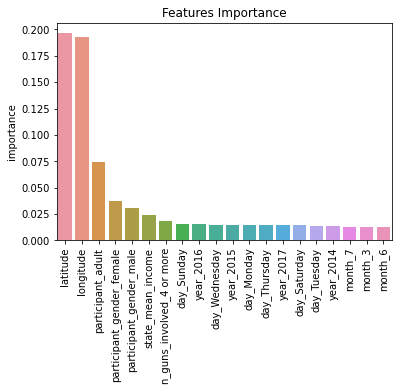

,importance
latitude,0.196288
longitude,0.192726
participant_adult,0.074756
participant_gender_female,0.037674
participant_gender_male,0.031009
state_mean_income,0.024246
n_guns_involved_4 or more,0.018672
day_Sunday,0.015970
year_2016,0.015791
day_Wednesday,0.015024


In [360]:
plot_feature_importance(model_rf, X_train.columns)

##(b)

Now I will train another model without the single most important feature

In [361]:
X_train1 = X_train.drop(columns=['latitude'])
model_less = RandomForestRegressor().fit(X_train1, y_train)
X_test1 = X_test.drop(columns=['latitude'])

In [362]:
pred1 = model_less.predict(X_test1)

In [363]:
rmse1 = np.sqrt(mean_squared_error(y_test, pred1))
mae1 = mean_absolute_error(y_test, pred1)
less_r2 = model_less.score(X_test1, y_test)

In [364]:
print("RMSE without most important feature: {:.2f}".format(rmse1))
print("MAE without most important  feature: {:.2f}".format(mae1))
print("R^2 without most important  feature: {:.2f}".format(less_r2))

RMSE without most important feature: 0.49
MAE without most important  feature: 0.36
R^2 without most important  feature: 0.04


In [365]:
top4 = ['latitude', 'longitude', 'participant_adult', 'participant_gender_female']

Now I will train another model e with only the top 4.

In [366]:
X_train2 = X_train[top4]
model_top4 = RandomForestRegressor().fit(X_train2, y_train)
X_test2 = X_test[top4]

In [367]:
pred2 = model_top4.predict(X_test2)

In [368]:
rmse2 = np.sqrt(mean_squared_error(y_test, pred2))
mae2 = mean_absolute_error(y_test, pred2)
top4_r2 = model_top4.score(X_test2, y_test)


In [369]:
print("RMSE top 4 features: {:.2f}".format(rmse2))
print("MAE top 4 features: {:.2f}".format(mae2))
print("R^2 top 4 features: {:.2f}".format(top4_r2))

RMSE top 4 features: 0.52
MAE top 4 features: 0.35
R^2 top 4 features: -0.07


We can conclude that the model without the most important feature performed better performance on the RMSE but it is small different than the model with top 4 features. 

Also I can see the metric of the model without the most important feature almost  same as the full model, the R^2 score on the full model is the best, and it make sence as they cant explain the data variance.

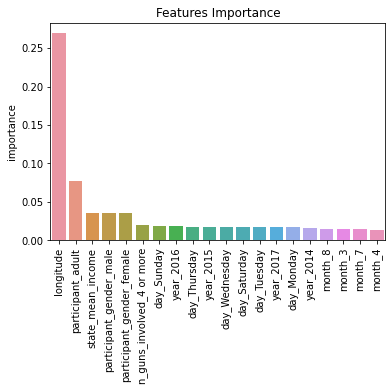

,importance
longitude,0.269087
participant_adult,0.077295
state_mean_income,0.035764
participant_gender_male,0.035557
participant_gender_female,0.035352
n_guns_involved_4 or more,0.020465
day_Sunday,0.019371
year_2016,0.018985
day_Thursday,0.018009
year_2015,0.017817


In [370]:
plot_feature_importance(model_less, X_train1.columns)

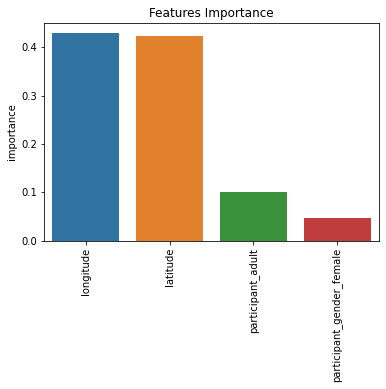

,importance
longitude,0.428875
latitude,0.423944
participant_adult,0.100899
participant_gender_female,0.046282


In [371]:
plot_feature_importance(model_top4, X_train2.columns)

We can see in all the important feature importance that the the main features are still in high place.

#Question 4 

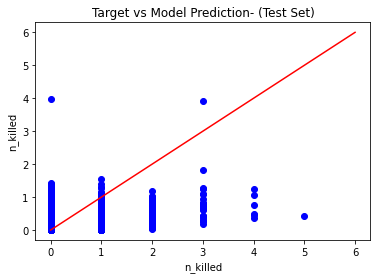

In [391]:
plt.scatter(y_test["n_killed"], model_rf.predict(X_test), color = 'blue')
plt.plot(list(range(7)), list(range(7)), color = 'red')
plt.title('Target vs Model Prediction- (Test Set)')
plt.xlabel('n_killed')
plt.ylabel('n_killed')
plt.show()

We can see that the most of the times the model presict number between zero to 1.5, also we can conclude from the graph that the model doesnt predict well when n_killed getting higher.

Now we will calculate the error to look which rows had the biggests error and then we can conclude.

I normalized the error by sub the mean and divide by sd.

In [392]:
e = list(y_test['n_killed']) - y_hat

In [393]:
e2 = y_test['n_killed'] - y_hat

In [394]:
e_n = (e - np.mean(e)) / np.std(e)

In [395]:
e_n2 = (e2 - np.mean(e2)) / np.std(e2)

In [396]:
e_n2.describe()

count    7.235000e+03
mean     9.820909e-18
std      1.000069e+00
min     -8.057771e+00
25%     -5.417771e-01
50%     -2.566174e-01
75%      8.173694e-03
max      9.336968e+00
Name: n_killed, dtype: float64

We can see the 28 rows that had the most error.

In [397]:
X_test[np.abs(list(e_n)) > 4].head()

,latitude,longitude,participant_gender_male,participant_gender_female,participant_adult,participant_teen,participant_child,gun_stolen_n,gun_unstolen_n,gun_unknown_n,...,month_12,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,n_guns_involved_2.0,n_guns_involved_3.0,n_guns_involved_4 or more
179,45.4629,-122.8980,18.0,6.0,30.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
524,34.9003,-114.5960,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
628,38.5809,-90.2985,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
685,29.9673,-90.1016,5.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1341,36.1332,-95.8551,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1


In [398]:
outliers = X_test[np.abs(list(e_n)) > 3]
not_outliers = X_test[~(np.abs(list(e_n)) > 3)]

In [400]:
lst = ['longitude','participant_adult','participant_gender_female','state_mean_income','participant_gender_male','n_guns_involved_4 or more','day_Wednesday','day_Monday','day_Saturday']

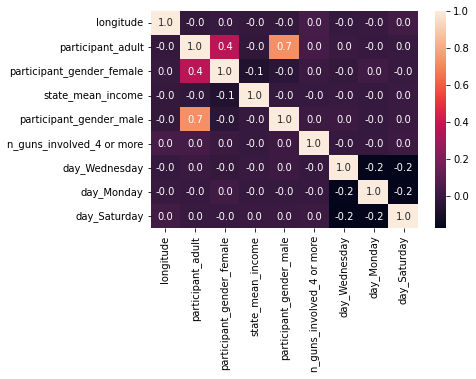

In [401]:
sns.heatmap(X_test[lst].corr(), annot=True, fmt=".1f")

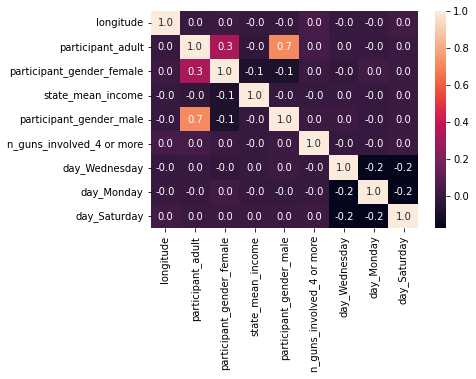

In [402]:
sns.heatmap(not_outliers[lst].corr(), annot=True, fmt=".1f")

We can notice that the important features correlation are very similar between the outliers and the normal data.

In [403]:
outliers['participant_gender_male'].mean()

2.0727272727272728

In [404]:
not_outliers['participant_gender_male'].mean()

1.4137543859649122

In [405]:
outliers['n_guns_involved_4 or more'].mean()

0.39090909090909093

In [406]:
not_outliers['n_guns_involved_4 or more'].mean()

0.447859649122807

We can see for wxample these two differences between the outliers data and the normal data, and we can conclude that maybe with more data we could predict better.